# 3. Beamforming for location

We now calculate the beamforming. This consists of calculating waveform features first (envelopes, kurtosis, etc.) and to shift-and-stack them according to the points in the 3D source-search grid previously calculated.

## Contents

* [Calculate waveform features](#calculate-waveform-features)

* [Read travel times](#read-travel-times)

* [Show an example waveform](#show-an-example-envelope)

In [49]:
import beampower as bp
import glob
import numpy as np
import os
import pandas as pd
import tqdm
import xarray as xr

from matplotlib import pyplot as plt
from scipy import signal, stats
from obspy import read, read_inventory, UTCDateTime
from obspy.geodetics.base import locations2degrees, degrees2kilometers

In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Calculate waveform features

We first transform the waveforms in a representation that is best suited for beamforming. In this notebook, we consider the envelope calculated from the Hilbert transform. Other transforms can also be better depending on the data and task.

The following function calculates the envelope of a one-dimensional signal with the Hilbert transform. First, the data is normalized by the mean absolute deviation over the entire signal window. The envelope is clipped as a maximum of $10^5$ times the mean absolute deviation of the envelope.

In [51]:
def envelope(x):
    """Envelope transformation.

    Calculate the envelope of the input one-dimensional signal with the Hilbert
    transform. The data is normalized by the mean absolute deviation over the
    entire signal window first. The envelope is clipped at a maximum of 10^5
    times the mad of the envelope.
    
    Arguments
    ---------
    x: array-like
        The input one-dimensional signal.
    
    Returns
    -------
    array-like
        The envelope of x with same shape than x.
    """
    # Normalization
    x_mad = stats.median_abs_deviation(x)
    x_mad = 1.0 if x_mad == 0.0 else x_mad

    # Envelope
    x = np.abs(signal.hilbert(x / x_mad))
    
    # Clip
    x_max = 10.0 ** (5.0 * stats.median_abs_deviation(x))
    return x.clip(None, x_max)

We first initialize the waveform features as a `Dataarray` in order to easily keep track of the physical dimensions later.

In [52]:
DIRPATH_INVENTORY = "../data/processed/*.xml"
DIRPATH_WAVEFORMS = "../data/processed/*.mseed"

# Header
filepaths_waveforms = glob.glob(DIRPATH_WAVEFORMS)
headers = read(DIRPATH_WAVEFORMS, headonly=True)

# Initialize
waveform_features = xr.DataArray(
    dims=["station", "channel", "time"],
    coords={
        "channel": list(set([header.stats.channel[-1] for header in headers])),
        "station": list(set([header.stats.station for header in headers])),
        "time": pd.to_datetime(headers[0].times("timestamp"), unit="s")
    }
)

# Transform each file
for trace in tqdm.tqdm(read(DIRPATH_WAVEFORMS), desc="Envelopes"):
    info = trace.stats
    index = {"station": info.station, "channel": info.channel[-1]}
    waveform_features.loc[index] = envelope(trace.data)


Envelopes: 100%|██████████| 24/24 [00:06<00:00,  3.62it/s]


## Show an example envelope

Example of a waveform with corresponding envelope.

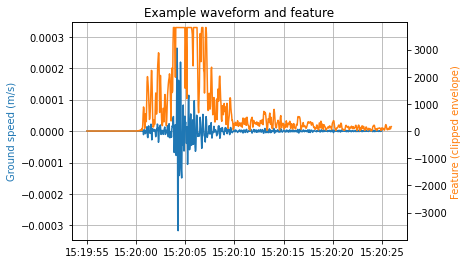

In [53]:
START, END = "2013-04-23 15:19:55", "2013-04-23 15:20:25"

# Get example waveform
trace = read(filepaths_waveforms[2])[0]
trace.trim(starttime=UTCDateTime(START), endtime=UTCDateTime(END))
times = pd.to_datetime(trace.times("timestamp"), unit="s")

# Plot waveform
fig, ax = plt.subplots()
ax.plot(times, trace.data)
ymax = max(np.abs(ax.get_ylim()))
ax.set_ylim(-ymax, ymax)
ax.set_ylabel("Ground speed (m/s)", color="C0")
ax.set_title("Example waveform and feature")
ax.grid()

# Plot envelope on a second axe (not the same scale)
ax = ax.twinx()
waveform_features.sel(
    station=trace.stats.station,
    channel=trace.stats.channel[-1],
    time=slice(START, END),
).plot(ax=ax, color="C1")

# Labels
ax.set_ylabel("Feature (clipped envelope)", color="C1")
ax.set_ylim(bottom=-max(ax.get_ylim()))
ax.set_title("")
plt.show()

## Initialize beamforming

Get the travel times obtained from [our notebook #2](2_travel_times.ipynb) on travel time calculation.

In [54]:
ravel_shape = ["latitude", "longitude", "depth"]
sampling_rate = headers[0].stats.sampling_rate

# Time delays
travel_times = xr.load_dataarray("../data/travel_times.nc")
time_delays = travel_times.stack(source=ravel_shape)
time_delays = time_delays.transpose("source", "station", "phase")
time_delays = np.round(sampling_rate * time_delays)

# Phase weights
weights_phase = xr.ones_like(waveform_features.isel(time=0).drop("time"))
weights_phase = weights_phase.expand_dims({"phase": 2})
weights_phase = weights_phase.assign_coords({"phase": list("PS")})
weights_phase = weights_phase.copy()
weights_phase.loc[{"channel": ["E", "N"], "phase": "P"}] = 0.0
weights_phase.loc[{"channel": "Z", "phase": "S"}] = 0.0
weights_phase = weights_phase.transpose("station", "channel", "phase")

# Sources weights
weights_sources = np.ones(time_delays.shape[:-1])

## Calculate beamforming

We extract the beamforming maximum at every time stamp in the hole grid.

In [55]:
beam_max, beam_argmax = bp.beampower.beamform_max(
    waveform_features.to_numpy().astype(np.float32),
    time_delays.to_numpy().astype(np.int32),
    weights_phase.to_numpy().astype(np.float32),
    weights_sources.astype(np.float32),
    device="cpu"
)

## Aggregate beam outputs

The output of the beamforming operation are assembled in a `Dataarray` in order to simplify array manipulation and detection.

In [56]:
# Get arrays
beam = xr.DataArray(data=beam_max, coords=waveform_features["time"].coords)
beam = beam.to_dataset(name="beam_max")

# Source coordinates
for dim in ravel_shape:
    coordinates = time_delays[dim].to_numpy()[beam_argmax]
    beam = beam.assign({dim: ("time", coordinates)})

## Detect

We detect the maxima with find peaks and use a threshold criterion to keep only the prominent peaks (or events).

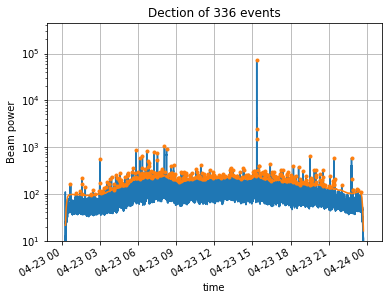

In [57]:
MIN_DETECTION_INTERVAL = int(30 * sampling_rate)

# Detect
peaks = signal.find_peaks(beam.beam_max, distance=MIN_DETECTION_INTERVAL)
events = beam.isel(time=peaks[0])

# Threshold
window_length = int(1800 * sampling_rate)
threshold = 2 * beam.beam_max.rolling(time=window_length, center=True).median()
beam = beam.assign({"threshold": ("time", threshold.to_numpy())})
events = events.isel(time=events.beam_max > threshold)

# Show
beam.beam_max.plot()
threshold.plot()
events.beam_max.plot(marker=".", ls="none", c="C1")
plt.semilogy()
plt.ylim(bottom=10)
plt.ylabel("Beam power")
plt.grid()
plt.title(f"Dection of {len(events.time)} events")
plt.show()

## Show detection

We detect the maxima with find peaks and use a threshold criterion to keep only the prominent peaks (or events).

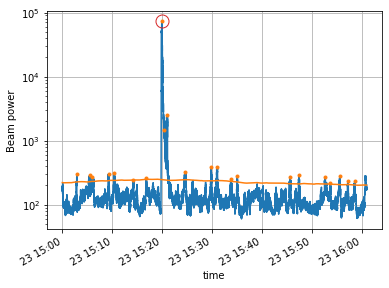

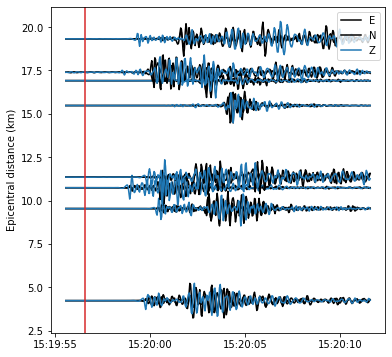

In [58]:
COLORS = {"E": "k", "N": "k", "Z": "C0"}

select = slice("2013-04-23 15:00", "2013-04-23 16:00")
inventory = read_inventory(DIRPATH_INVENTORY)
detector_zoom = beam.sel(time=select)
events_zoom = events.sel(time=select)

# Show
detector_zoom.beam_max.plot()
detector_zoom.threshold.plot()
events_zoom.beam_max.plot(marker=".", ls="none", c="C1")
plt.semilogy()
plt.grid()
plt.ylabel("Beam power")

# Watch peak
event_watch = events_zoom.isel(time=events_zoom.beam_max.argmax())
plt.plot(event_watch.time, event_watch.beam_max, "oC3", ms=13, mfc="none")

# str(event_watch.time.data)
date = UTCDateTime(str(event_watch.time.data))

# Get waveform
fig, ax = plt.subplots(1, figsize=(6, 6))
for index, trace in enumerate(read(DIRPATH_WAVEFORMS)):

    # Get trace and info
    trace.trim(date - 1, date + 15)        
    trace.filter(type="lowpass", freq=5)
    times = pd.to_datetime(trace.times("timestamp"), unit="s")
    data = trace.data / np.abs(trace.data).max()

    coords = inventory.get_coordinates(trace.id)
    p1 = event_watch.latitude.data, event_watch.longitude.data
    p2 = [coords[dim] for dim in ["latitude", "longitude"]]
    distance = degrees2kilometers(locations2degrees(*p1, *p2))

    # Plot trace
    ax.plot(times, data + distance, color=COLORS[trace.stats.channel[-1]])
    
# Labels
ax.set_ylabel("Epicentral distance (km)")
ax.axvline(date, color="C3")
ax.legend([key for key in COLORS])
    

## Show all detections

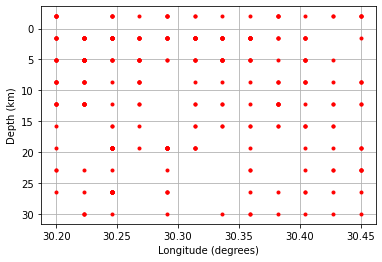

In [59]:
plt.plot(events.longitude, events.depth, ".r")
plt.xlabel("Longitude (degrees)")
plt.ylabel("Depth (km)")
plt.gca().invert_yaxis()
plt.grid()